In [1]:
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#from fbprophet import Prophet
import datetime 
import warnings 
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
warnings.simplefilter('ignore')
import math
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
import scipy.stats as sct
from sklearn import preprocessing
import time as time

In [2]:
NB_PRED = 10271
TARGET = 'RES1_BASE'

In [3]:
df = pd.read_csv("../dataset/inout.csv")

In [4]:
def change_date_format(date):
    """We want to have this format for the prophet API : YYYY-MM-DD HH:MM:SS"""
    return datetime.datetime.strptime(date, '%d/%m/%Y %H:%M').strftime('%Y-%m-%d %H:%M:00')

In [5]:

def getxy(hour):
    """[cos sin transformation for hour]

    Args:
        hour ([int or float]): [hour timestamp]

    Returns:
        [float]: [sin and cos of hour]
    """
    x = math.sin((180 - hour * 15)/180 * 3.141)
    y = math.cos((180 - hour * 15)/180 * 3.141)
    return x, y

def keep_relevant_features(df):
    """[Keep all relevant featres]

    Args:
        df ([df.Dataframe]): [Dataframe with all features]

    Returns:
        [df.Dataframe]: [Dataframe with only relevant features]
    """
    targets = ['RES1_BASE', 'RES11_BASE','PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC', 'PRO2_HP']
    myfeatures=df.columns
    correlation=df.corr()
    colonnes=df.columns
    for ligne in colonnes:
        for col in colonnes:
            if 0.9<abs(correlation[ligne][col])<1:
                if col in myfeatures and col not in targets:
                    myfeatures=myfeatures.drop(col)
            elif correlation[ligne][col]==1:
                break
    for col in df.columns:
        if col not in myfeatures: 
            df=df.drop(columns=[col])
    return df
    
def symetric(df_reduced):
    """[To get symetric and more normal likely distribution]

    Args:
        df_reduced ([pd.Dataframe]): [Dataset with only relevant features]

    Returns:
        [pd.Dataframe]: [Dataset with corrected features distribution]
    """
    list_to_box=[]
    list_quantile=[]
    targets = ['RES1_BASE', 'RES11_BASE','PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC', 'PRO2_HP']
    for feature in df_reduced.columns.drop(targets):
        skew=sct.skew(df_reduced[feature])
        if abs(skew)>1:
            list_to_box.append(feature)
        else:
            list_quantile.append(feature)
    for elt in list_to_box:
        yj = PowerTransformer(method='yeo-johnson')
        data = np.array(df_reduced[elt])
        reshaped_data = np.array(data).reshape(-1, 1)
        yj.fit(reshaped_data)
        df_reduced[elt] = yj.transform(reshaped_data)
        
    rng = np.random.RandomState(304)  
    for elt in list_quantile:
        qt = QuantileTransformer(output_distribution='normal',random_state=rng)
        data = np.array(df_reduced[elt])
        reshaped_data = np.array(data).reshape(-1, 1)
        qt.fit(reshaped_data)
        df_reduced[elt] = qt.transform(reshaped_data)
    return df_reduced

def encodage(df):
    """[to encode dataset and non numeric features]

    Args:
        df ([pd.Dataframe]): [Dataset to be encoded]

    Returns:
        [pd.Dataframe]: [Encoded dataframe]
    """
    df_indexed=df.set_index("Horodate_UTC")
    df_indexed.index = pd.to_datetime(df.set_index("Horodate_UTC").index)
    return df_indexed


def feature_engineering(df_indexed):
    """[Features engineering with regroup different steps]

    Args:
        df_indexed ([pd.Dataframe]): [Dataset]

    Returns:
        [pd.Dataframe]: [Dataset with new features]
    """
    df_indexed.drop(["Mois","IDS","Horodate"],inplace=True,axis=1)
    df_indexed = keep_relevant_features(df_indexed)
    for i in df_indexed.columns[df_indexed.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
        df_indexed[i].fillna(df_indexed[i].mean(),inplace=True)
    df_indexed = symetric(df_indexed)
    df_indexed=df_indexed.fillna(df_indexed.mean())
    ss= preprocessing.StandardScaler()
    targets = ['RES1_BASE', 'RES11_BASE','PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC', 'PRO2_HP']
    columns_targ = df_indexed.columns.drop(targets)
    df_indexed[columns_targ] = ss.fit_transform(df_indexed[columns_targ])
    df_indexed["Year"]=df_indexed.index.year
    df_indexed["Month"]=df_indexed.index.month.map(lambda x : np.cos(x*2*np.pi/12))
    df_indexed["Day"]=df_indexed.index.day.map(lambda x : np.cos(x*2*np.pi/31))
    df_indexed["Week_day"]=df_indexed.index.weekday.map(lambda x : np.cos(x*2*np.pi/7))
    df_indexed["Hour_X"],df_indexed["Hour_Y"]=zip(*pd.Series(df_indexed.index.hour).apply(getxy))
    return df_indexed

def imputation(df):
    """[Imputation task to remove and trait missing values]

    Args:
        df ([pd.Dataframe]): [Preprocessed Dataset ]

    Returns:
        [pd.Dataframe]: [Imputed Dataset]
    """
    # df.dropna(thresh=len(df)*0.9,axis=1,inplace=True)
    # df.dropna(thresh=len(df)*0.5,axis=0,inplace=True)
    return df


def preprocessing_tuned(df):
    """[Processing the dataset]

    Args:
        df ([pd.Dataframe]): [Dataset]

    Returns:
        [tuple]: [X,y Preprocessed Dataset with X the samples and y the targets]
    """
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    targets = ['RES1_BASE', 'RES11_BASE','PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC', 'PRO2_HP']
    X = df.drop(targets, axis=1)
    y = df[targets]
    return X,y

In [6]:
X,y= preprocessing_tuned(df)

In [7]:
mask = X.index<"2017-01-01 00:00:00"
X= X[mask]
regressors = [X.columns[3]]
mask_pred = (X.index > "2016-06-01 00:00:00" ) & (X.index <= "2016-12-31 23:30:00")
X_past,X_fore =  X[~mask_pred],X[mask_pred]

In [8]:
mydf=df[['Horodate_UTC',TARGET]]
mydf["Horodate_UTC"]=mydf["Horodate_UTC"].apply(change_date_format)
mydf=mydf.rename(columns={"Horodate_UTC":"ds",TARGET:"y"})
print(df.shape)

(70128, 33)


In [9]:
def split(df,column):
    mask = df[column]<"2017-01-01 00:00:00"
    df= df[mask]
    mask_pred = (df[column] > "2016-06-01 00:00:00" ) & (df[column] <= "2016-12-31 23:30:00")
    return df[~mask_pred],df[mask_pred]

In [10]:
mydf_past,mydf_forecast=split(mydf,"ds")
for regressor in regressors : 
    print(regressor)
    mydf_past[regressor] = X_past[regressor].values

Température normale lissée (°Celcius)


In [11]:
m=Prophet(interval_width=0.95)
m.add_country_holidays(country_name='FR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name="season", period = 91.3125 , fourier_order=7)
for regressor in regressors: 
    m.add_regressor(regressor)
t_start = time.time()
m.fit(mydf_past)
training_time = round(time.time()-t_start,3)

Initial log joint probability = -1258.47
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        112364   0.000404243       3088.36           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        112613    0.00136516       1347.42           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        112656    0.00197674       3883.53           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        112704    0.00491385       3281.59           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        112737     0.0132264       586.183           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [12]:
future=m.make_future_dataframe(periods=NB_PRED,freq= '30min')
for regressor in regressors : 
    future[regressor] = X[regressor].values
t_start = time.time()
forecast=m.predict(future)
forecast_time = round(time.time()-t_start,3)

In [13]:
print(forecast.shape)
print(mydf_past.shape)
print(mydf_forecast.shape)

(56404, 70)
(46133, 3)
(10271, 2)


In [43]:
y_hat=forecast["yhat"][-NB_PRED:]
y_hat_lower=forecast["yhat_lower"][-NB_PRED:]
y_hat_upper=forecast["yhat_upper"][-NB_PRED:]
y_true = mydf_forecast["y"][-NB_PRED:]
date = forecast["ds"][-NB_PRED:]
error = round(mean_squared_error(y_hat,y_true),3)
print(f"Error on {NB_PRED} points : {error} ")

Error on 10271 points : 0.014 


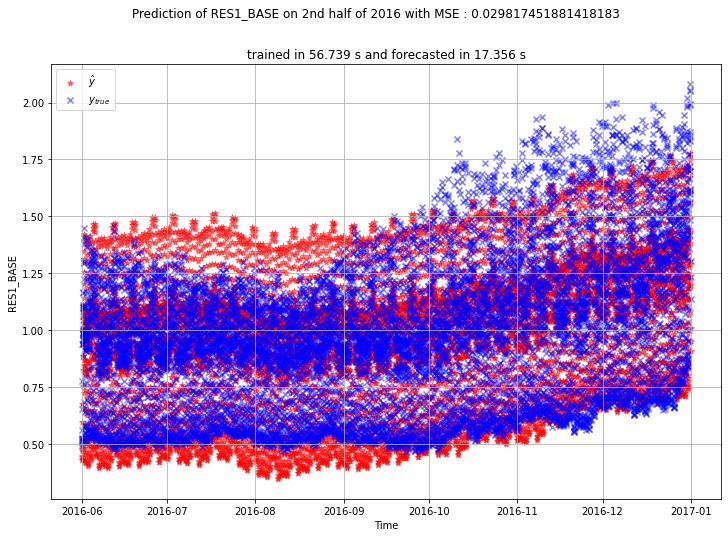

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize=(12,8))

plt.scatter(date,y_hat,c="r",label="$\hat{y}$",marker="*",alpha=0.5)
plt.scatter(date,y_true,c="b",label="$y_{true}$",marker="x",alpha=0.5)
plt.suptitle(f"Prediction of {TARGET} on 2nd half of 2016 with MSE : {error}")
plt.title(f"trained in {training_time} s and forecasted in {forecast_time} s")
plt.ylabel(f"{TARGET}")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()
plt.savefig(f"../outputs/Prediction of {TARGET} on 2nd half of 2016.png")

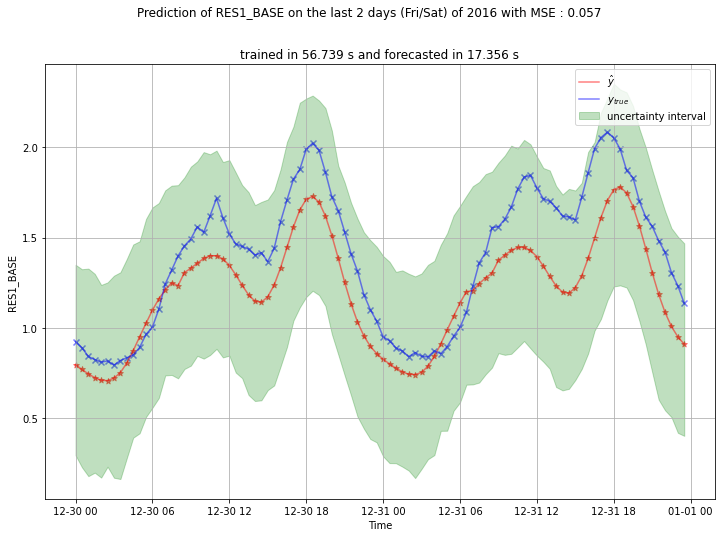

<Figure size 432x288 with 0 Axes>

In [47]:
two_days = 24*2*2
error = round(mean_squared_error(y_hat[-two_days:],y_true[-two_days:]),3)
plt.figure(figsize=(12,8))
plt.scatter(date[-two_days:],y_hat[-two_days:],c="r",marker="*",alpha=0.5)
plt.scatter(date[-two_days:],y_true[-two_days:],c="b",marker="x",alpha=0.5)
plt.plot(date[-two_days:],y_hat[-two_days:],c="r",label="$\hat{y}$",alpha=0.5)
plt.plot(date[-two_days:],y_true[-two_days:],c="b",label="$y_{true}$",alpha=0.5)

# plt.scatter(date[-two_days:],y_hat_upper[-two_days:],c="r",marker="*",alpha=0.5)
# plt.scatter(date[-two_days:],y_hat_lower[-two_days:],c="b",marker="x",alpha=0.5)
# plt.plot(date[-two_days:],y_hat_upper[-two_days:],c="r",label="$\hat{y}_{upper}$",alpha=0.5)
# plt.plot(date[-two_days:],y_hat_lower[-two_days:],c="b",label="$\hat{y}_{lower}$",alpha=0.5)
plt.fill_between(date[-two_days:],y_hat_lower[-two_days:],y_hat_upper[-two_days:],label="uncertainty interval",color="green",alpha=0.25)
plt.suptitle(f"Prediction of {TARGET} on the last 2 days (Fri/Sat) of 2016 with MSE : {error}")
plt.title(f"trained in {training_time} s and forecasted in {forecast_time} s")
plt.ylabel(f"{TARGET}")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()
plt.savefig(f"../outputs/Prediction of {TARGET} on 2nd half of 2016.png")

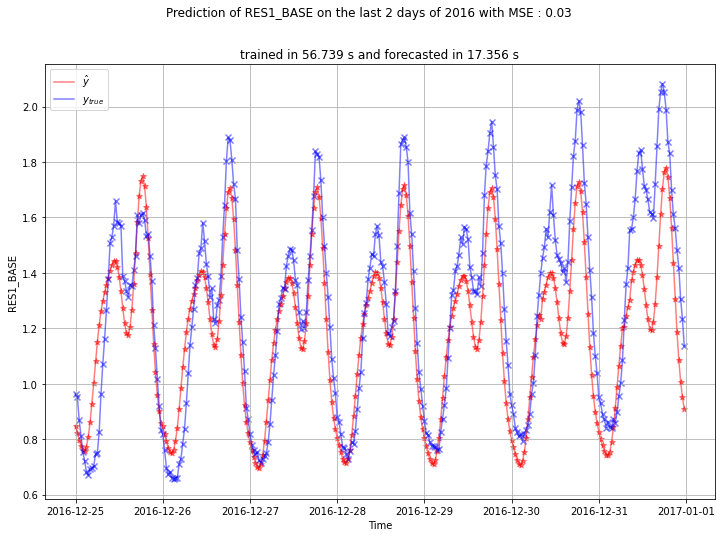

In [31]:
week = 24*2*7
error = round(mean_squared_error(y_hat[-week:],y_true[-week:]),3)
plt.figure(figsize=(12,8))
plt.scatter(date[-week:],y_hat[-week:],c="r",marker="*",alpha=0.5)
plt.scatter(date[-week:],y_true[-week:],c="b",marker="x",alpha=0.5)
plt.plot(date[-week:],y_hat[-week:],c="r",label="$\hat{y}$",alpha=0.5)
plt.plot(date[-week:],y_true[-week:],c="b",label="$y_{true}$",alpha=0.5)
plt.suptitle(f"Prediction of {TARGET} on the last 2 days of 2016 with MSE : {error}")
plt.title(f"trained in {training_time} s and forecasted in {forecast_time} s")
plt.ylabel(f"{TARGET}")
plt.xlabel("Time")
plt.legend()
plt.grid()
plt.show()